# Trajectory optimization and stabilization

This example notebook shows trajectory optimization with the Hermite-Simpson collocation method and trajectory stabilization with a finite-horizon LQR controller. These methods are demonstrated for the model of an acrobot, a two-link underactuated robot.

## Acrobot model

An acrobot, see schematic below, is a robotic arm with two links and a single actuator at the elbow joint. The state of the acrobot is described by the angles $q_1$ and $q_2$ of the two links, and the control input is the torque $u=\tau$ applied at the elbow joint.

<img src="../media/acrobot.png" alt="acrobot" style="width: 400px;"/>


All the parameters and variables in the acrobot model are described in the Table below.

| Quantity                    | Symbol             | Notes              |
|-----------------------------|--------------------|----------------------|
| Angular displacement of first arm        | $q_1$         |                      |
| Angular diaplacement of the second arm            | $q_2$         |      |
| Control torque              | $u$              |  torque at elbow $\tau$                    |
| | | |
| Length of the first arm                      | $l_1$              |                      |
| Length of the second arm                      | $l_2$              |  Doesn't appear in dynamics                    |
| Distance from base to the center-of-mass of the first arm                      | $l_{c_1}$              |                      |
| Distance from elbow to the center-of-mass of the first arm                      | $l_{c_2}$              |                      |
| Moment of inertia of the first arm about its pivot                      | $I_1$              |                      |
| Moment of inertia of the second arm about its pivot                      | $I_2$              |                      |
| Mass of the first arm                      | $m_1$              |                      |
| Mass of the second arm                      | $m_2$              |                      |
| Acceleration due to gravity | $g$              |                      |

Denoting $\mathbf{q} = [q_1, q_2]^T$ and $\mathbf{u} = [u]$ as the state and control input, respectively, the equations of motion for the acrobot are given by (see [1] for details)

$$ \mathbf{M}(\mathbf{q})\ddot{\mathbf{q}} + \mathbf{C}(\mathbf{q}, \dot{\mathbf{q}})\dot{\mathbf{q}} + \mathbf{G}(\mathbf{q}) = \boldsymbol{\tau}_g(\mathbf{q}) + \mathbf{B}\mathbf{u}, $$
where $\mathbf{M}(\mathbf{q})$ is the mass matrix, $\mathbf{C}(\mathbf{q}, \dot{\mathbf{q}})$ is the matrix for Coriolis and centrifugal terms, $\mathbf{G}(\mathbf{q})$ are the gravitational terms, $\boldsymbol{\tau}_g(\mathbf{q})$ are the torques due to gravity, and $\mathbf{B}$ is the control input matrix. Denoting, $\cos(q_1)$ as $c_1$, $\sin(q_1)$ as $s_1$, and $\sin(q_1 + q_2)$ as $s_{1+2}$, these matrices are [1]:

\begin{align} 
\mathbf{M}(\mathbf{q}) &= \begin{bmatrix} I_1 + I_2 + m_2 l_1^2 +
      2m_2 l_1 l_{c2} c_2 & I_2 + m_2 l_1 l_{c2} c_2 \\ I_2 + m_2 l_1 l_{c2} c_2
      & I_2 \end{bmatrix},\\[15pt]
      \mathbf{C}(\mathbf{q},\dot{\mathbf{q}}) &=
      \begin{bmatrix} -2 m_2 l_1 l_{c2} s_2 \dot{q}_2 & -m_2 l_1 l_{c2} s_2
      \dot{q}_2 \\ m_2 l_1 l_{c2} s_2 \dot{q}_1 & 0 \end{bmatrix}, \\[15pt]
      \boldsymbol{\tau}_g(\mathbf{q}) &= \begin{bmatrix} -m_1 g l_{c1}s_1 - m_2 g (l_1 s_1 +
      l_{c2}s_{1+2}) \\ -m_2 g l_{c2} s_{1+2} \end{bmatrix},\\[15pt]
      \mathbf{B} &=
      \begin{bmatrix} 0 \\ 1 \end{bmatrix}. 
\end{align}

As usual, we can write the above equations as first-order differential equations by introducing the state vector ${x} = [q_1, q_2, \dot{q}_1, \dot{q}_2]^T$.

The LeafSystem for the Acrobot is implemented in `collimator/models/acrobot.py`.


## Modelling without any control

With the Acrobot LeafSystem, we can simulate its dynamics and visualise the results. We show this below for zero elbow torque.

In [1]:
import jax
import jax.numpy as jnp
import collimator

from collimator.simulation import SimulatorOptions

from collimator.library import Constant, Clock, SourceBlock

from collimator.models import Acrobot, animate_acrobot

import matplotlib.pyplot as plt

In [2]:
config = {
    "m1": 1.0,
    "m2": 1.0,
    "l1": 1.0,
    "lc1": 0.5,
    "lc2": 1.0,
    "I1": 0.083 + 0.5**2,
    "I2": 0.33 + 1.0,
    "g": 9.81,
}  # parameters of the acrobot

nx = 4  # state vector size
nu = 1  # control vector size

t0 = 0.0  # simulation start time
tf = 4.0  # simulation end time

x0 = jnp.array([jnp.pi / 16, jnp.pi / 16, 0.0, 0.0])  # initial state

In [3]:
builder = collimator.DiagramBuilder()
plant = Acrobot(x0=x0, **config, name="acrobot")

controller = Constant(jnp.array([0.0]), name="controller")  # zero torque

builder.add(plant)
builder.add(controller)

# builder.connect(plant.output_ports[0], controller.input_ports[0])
builder.connect(controller.output_ports[0], plant.input_ports[0])

diagram = builder.build()
diagram.pprint()

Initialized callback acrobot:tau with prereqs []
Initialized callback acrobot:acrobot_ode with prereqs [1, 2, 8]
Initialized callback acrobot:y_0 with prereqs [2]
Initialized callback controller:out_0 with prereqs [0]
|-- root
    |-- acrobot(id=1)
    |-- controller(id=2)


In [4]:
context = diagram.create_context()
context = context.with_continuous_state([x0])

recorded_signals = {
    "x": plant.output_ports[0],
    "u": controller.output_ports[0],
}

Tsolve = 4.0
options = SimulatorOptions(
    max_major_step_length=0.1,
)

results = collimator.simulate(
    diagram,
    context,
    (0.0, Tsolve),
    options=options,
    recorded_signals=recorded_signals,
)

In [5]:
animate_acrobot(results.outputs["x"][:, 0], results.outputs["x"][:, 1], interval=40)

## Trajectory optimization

A *trajectory* is a pair of $x(t)$ and $u(t)$. For a reference trajectory $x_{ref}(t)$ and $u_{ref}(t)$ in an interval $t\in[t_0, t_f]$ that our plant should follow, the goal of trajectory optimization is to obtain a set of control vector $u_{opt}$, which when applied to the plant would produce a trajectory $x_{opt}$ that closely follows the reference trajectory. For instance, for the acrobot we may want to obtain such a trajectory for the acrobot to swing-up, starting from the vertically own orientation. Such an optimal trajectory can be obtained by solving the following optimization problem, where we search for $u_{opt}(t)$ and $x_{opt}(t)$ such that their discrepancy with respect to $x_{ref}(t)$ and $u_{ref}(t)$ is minimised:

\begin{align}
u_{opt}(t) = \text{arg}\,\min\limits_{u(t)}\, \quad & [x(t_f) - x_{ref}(t_f)]^T Q_f [x(t_f) - x_{ref}(t_f)] + \int_{t_0}^{t_f} (x - x_{ref})^T Q (x - x_{ref}) \, dt +  \int_{t_0}^{t_f} (u - u_{ref})^T R (u - u_{ref}) \, dt, \\
\text{subject to} \quad & \dot{x} = f(x, u), \\
\text{and} \quad & x(t=t_0) = x_0,
\end{align}

where, $Q_f$, $Q$, and $R$ are positive definite matrices. $Q_f$ represents the penalty for the terminal state discrepancy at $t=t_f$, while $Q$ and $R$ represent the continuous-time penalties for the state and control vector discrepancies, respectively. The function $f(x, u)$ represents the dynamics of the system. Note that one can change the optimization problem to suit their needs. For example, if reaching a particular state at $t=t_f$ was important, then one may wish to impose an additional equality constraint of the form $x(t_f) = x_{ref}(t_f)$. Additionally, one may add bounds on the state and control variables.

The above problem is in continuous time. In order to solve it, we first discretize the optimization problem (typically in $N$ discrete steps in $[t_0, t_f]$). Such discretization requires many choices and leads to different methods for transcribing the continuous-time problem to discrete-time and the optimization methodology for solving the problem. For example, some common methods (see [1] and references therein for more details) are:
1. Direct transcription
2. Direct shooting
3. Hermite-Simpson collocation (also referred as direct collocation)

Here, we demonstrate how to use the Hermite-Simpson collocation method to solve the trajectory optimization problem for the acrobot model to swing-up in Collimator, which uses the `IPOPT` solver for nonlinear programming. The `solve_trajectory_optimzation` method of the `HermiteSimpsonNMPC` class can be utilized to solve the trajectory optimization problem. Let's look at the class first.

In [6]:
from collimator.library import HermiteSimpsonNMPC

print(HermiteSimpsonNMPC.__doc__)


    Implementation of nonlinear MPC with Hermite-Simpson collocation and IPOPT as the
    NLP solver.

    Input ports:
        (0) x_0 : current state vector.
        (1) x_ref : reference state trajectory for the nonlinear MPC.
        (2) u_ref : reference input trajectory for the nonlinear MPC.

    Output ports:
        (1) u_opt : the optimal control input to be applied at the current time step
                    as determined by the nonlinear MPC.

    Parameters:
        plant: LeafSystem or Diagram
            The plant to be controlled.

        Q: Array
            State weighting matrix in the cost function.

        QN: Array
            Terminal state weighting matrix in the cost function.

        R: Array
            Control input weighting matrix in the cost function.

        N: int
            The prediction horizon, an integer specifying the number of steps to
            predict. Note: prediction and control horizons are identical for now.

        dt: float:
   

For the trajectory optimization problem, we can disregard the inputs and the outputs, and just focus on creating the object of this class. The initialization parameters reveal that the problem is discretized into $N$ steps of length $dt$. We can provide the matrices $Q, R$, and $QN$, which is analogous to $Q_f$. Additionally, we can specify the lower and upper bounds on both the state and control vectors. Finally, we can specify whether we wish to include the terminal state and terminal control vector as constraints. Let's look at the `solve_trajectory_optimization` method:

In [7]:
print(HermiteSimpsonNMPC.solve_trajectory_optimzation.__doc__)


        Solve the NLP problem structure specified by `nlp_structure_ipopt`.

        This public method can be used to solve Trajectory Opimization problems, where
        the NLP solution needs to be obtained separately from the MPC loop. Once the
        above `solve` method is able to take initial guesses, the two methods can be
        combined into a single core solution method.

        Parameters:
        t_curr: float
            Current time.
        x_curr: Array
            Current state.
        x_ref: Array
            Reference trajectory for the state vector.
        u_ref: Array
            Reference trajectory for the control input vector.
        x_optvars_guess: Array
            Initial guess of the state trajectory.
        u_optvars_guess: Array
            Initial guess of the control input trajectory.

        Returns: Array
            Solution of the NLP problem.
        


Once the object is created, we can solve the trajectory optimization problem from `t_curr` ($t_0$) and `x_curr` ($x_0$), providing `x_ref` and `u_ref` and initial guesses. Note that for a discretization of $N$ steps, if the size of the state and control vectors are `nx` and `nu`, respectively, then `x_ref` and `u_ref` are of shapes `(N, nx)` and `(N, nu)`, respectively, i.e. their $i^\mathrm{th}$ row provides the target/reference at the $i^\mathrm{th}$ step.

### Swing-up for Acrobot
 
For the acrobot to swing-up, we don't really have a full time-varying reference trajectory. All we have is that, in the end, the acrobot should be in the swing-up position, i.e. $x_f = [\pi, 0, 0, 0]^T$, in some finite time, say $t_f=4$ seconds. We can choose a discretization of $N=21$ equal steps to reach $t_f$. Since we don't know the time-varying trajectory, we can choose `Q` and `QN` to be zero matrices, implying that we don't really penalize the deviations from the unknown time-varying reference trajectory. However, we do know the final state, so we can include this as a constraint. 

In [8]:
Q = 0.0 * jnp.eye(nx)  # state penalty matrix
QN = 0.0 * jnp.eye(nx)  # terminal state penalty matrix
R = 10.0 * jnp.eye(nu)  # control input penalty matrix

N = 21  # Discretization steps
t0 = 0.0  # Start time; end time `tf=4.0` defined earlier
dt = tf / N
t_vec = t0 + dt * jnp.arange(N + 1)  # vector of times at our discretization points

x0 = jnp.zeros(nx)  # initial state of the acrobot, vertically down

lb_u = jnp.array([-8.0])  # lower bound on the control torque
ub_u = jnp.array([8.0])  # upper bound on the control torque

x_up = jnp.array([jnp.pi, 0.0, 0.0, 0.0])  # the swing-up orientation: our target
u_up = jnp.array(
    [0.0]
)  # at the swing-up orientation the target torque is zero as the acrobot is balanced

x_ref = jnp.tile(
    x_up, (N + 1, 1)
)  # provide the swing-up state at all times (only the terminal value matters as it appears in the terminal constraint)
u_ref = jnp.tile(u_up, (N + 1, 1))  # zeros

u0 = jnp.array([0.0])
u_guess_0 = jnp.tile(u0, (N + 1, 1))  # initial guess for the solution trajectory

# Create the Hermite-Simpson object, configuring it our time duration, penalty matrices, bounds, and constraints
hs = HermiteSimpsonNMPC(
    Acrobot(x0=x0, **config, name="acrobot"),
    Q,
    QN,
    R,
    N,
    tf / N,
    lb_x=None,
    ub_x=None,
    lb_u=lb_u,
    ub_u=ub_u,
    include_terminal_x_as_constraint=True,
    include_terminal_u_as_constraint=True,
)

# Initial guess is important for a quick and good solution to the optimization problem
# Guesses below are taken from the "underactuated robotics" [1] demonstrations:
# https://deepnote.com/workspace/Underactuated-2ed1518a-973b-4145-bd62-1768b49956a8/project/096cffe7-416e-4d51-a471-5fd526ec8fab/notebook/acrobot-229d29e61b5b44cabccbc7ac3dd59881
t_traj_guess = jnp.array([0.0, 0.2, 1.4, 2.0, 4.0])
x_traj_guess = jnp.column_stack(
    (
        x0,
        jnp.array([0.35, -0.71, 2.63, -5.34]),
        jnp.array([-1.19, 0.77, -6.87, 15.17]),
        jnp.array([1.12, 2.48, 5.99, -3.22]),
        x_up,
    )
).T

guess_func = jax.vmap(jnp.interp, (None, None, 1))

x_guess_0 = guess_func(
    t_vec, t_traj_guess, x_traj_guess
).T  # interpolate the guess to our discretization times

x_and_u_opt = hs.solve_trajectory_optimzation(
    t0, x0, x_ref, u_ref, x_guess_0, u_guess_0
)

# the optimization solution is a flat array of flat trajectory for u and flat trajectory for x
u_opt_hs = x_and_u_opt[: (N + 1) * nu].reshape(N + 1, nu)
x_opt_hs = x_and_u_opt[(N + 1) * nu :].reshape(N + 1, nx)

Initialized callback acrobot:tau with prereqs []
Initialized callback acrobot:acrobot_ode with prereqs [1, 2, 8]
Initialized callback acrobot:y_0 with prereqs [2]
Initialized callback HermiteSimpsonNMPC_5_:u_0 with prereqs []
Initialized callback HermiteSimpsonNMPC_5_:u_1 with prereqs []
Initialized callback HermiteSimpsonNMPC_5_:u_2 with prereqs []
Initialized callback HermiteSimpsonNMPC_5_:y_0 with prereqs [8]

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



We can visualise the solution with the `animate_acrobot` utility.

In [9]:
animate_acrobot(
    x_opt_hs[:, 0],
    x_opt_hs[:, 1],
    title="Planned by Hermite-Simpson collocation",
    interval=200,
)

Note that this is just a solution to the optimization problem. It is not guaranteed, in fact it is unlikely, that the acrobot will get this very state $x_{opt}(t)$ as a solution to its dynamics if $u_{opt}(t)$ were applied as control. 

## Simulate with the planned trajectory (solution of trajectory optimization)

To simulate the Acrobot with the planned torques by the trajectory optimization solution, we can linearly interpolate the solution and pass it to our Acrobot LeafSystem. We can create this interpolant quite conveniently by declaring a `SourceBlock`, and providing a `vmap` version of the the `jnp.interp` function as its callback.

In [10]:
class InterpArray(SourceBlock):
    """
    Interpolate all columns of an array individually
    Params:
        t_vec: 1D array
        x_arr: nD array

    Input ports:
        (0): scalar time `t`

    Output ports:
        (0): 1D array x_arr(t) where the ith element of x_arr(t) is a
            linear interpolant of x_arr([:,i])(t_vec) evaluated
            at `t`.
    """

    def __init__(self, t_vec, x_arr, *args, **kwargs):
        self.t_vec = t_vec
        self.x_arr = x_arr
        self.interp_fun = jax.vmap(jnp.interp, (None, None, 1))
        super().__init__(
            lambda t: self.interp_fun(t, self.t_vec, self.x_arr), *args, **kwargs
        )

With this new `InterpArray` block available to us, we can create a diagram for our acrobot system controlled by the planned torques as follows:

In [11]:
builder = collimator.DiagramBuilder()

plant = builder.add(Acrobot(x0=x0, **config, name="acrobot"))
controller = builder.add(InterpArray(t_vec, u_opt_hs, name="control"))

builder.connect(controller.output_ports[0], plant.input_ports[0])

diagram = builder.build()
diagram.pprint()

Initialized callback acrobot:tau with prereqs []
Initialized callback acrobot:acrobot_ode with prereqs [1, 2, 8]
Initialized callback acrobot:y_0 with prereqs [2]
Initialized callback control:out_0 with prereqs [1]
|-- root
    |-- acrobot(id=6)
    |-- control(id=7)


Next, we can simulate the system and animate the output

In [12]:
context = diagram.create_context()

recorded_signals = {
    "x": plant.output_ports[0],
    "u_opt": controller.output_ports[0],
}

results = collimator.simulate(
    diagram,
    context,
    (0.0, tf),
    options=options,
    recorded_signals=recorded_signals,
)

In [13]:
animate_acrobot(
    results.outputs["x"][:, 0],
    results.outputs["x"][:, 1],
    title="Simulation with planned torques [unstable]",
    interval=40,
)

The acrobot does follow  our refrence in the beginning but then deviates significantly from the desired trajectory. One may say that the trajectory obtained by the process of trajectory optimization is unstable. This is indeed true, and we must stabilize the trajectory. One method for this is the finite-horizon linear quadratic regulator. This is demonstrated next.

## Trajectory stabilization with Finite-horizon Linear Quadratic Regulator

Previously (see the LQR example notebook), we saw how the LQR was used to stabilize the plant around an equilibrium point. Here, we consider its extension of stabilizing the plant around a trajectory. The general idea is simple, instead of linearising a plant around an equilibrium point, we linearise the plant around a nominal trajectory. Subsequently, we minimise a quadratic function representing deviations from a desired trajectory. The reader is referred to Chapter 8 of [1] for all things related to the LQR.

In Collimator, the finite-horizon LQR is avilable as the `FiniteHorizonLinearQuadraticRegulator` block.

In [14]:
from collimator.library import FiniteHorizonLinearQuadraticRegulator

print(FiniteHorizonLinearQuadraticRegulator.__doc__)


    Finite Horizon Linear Quadratic Regulator (LQR) for a continuous-time system.
    Solves the Riccati Differential Equation (RDE) to compute the optimal control
    for the following finitie horizon cost function over [t0, tf]:

    Minimise cost J:

        J = [x(tf) - xd(tf)].T Qf [x(tf) - xd(tf)]
            + ∫[(x(t) - xd(t)].T Q [(x(t) - xd(t)] dt
            + ∫[(u(t) - ud(t)].T R [(u(t) - ud(t)] dt
            + 2 ∫[(x(t) - xd(t)].T N [(u(t) - ud(t)] dt

    subject to the constraints:

    dx(t)/dt - dx0(t)/dt = A [x(t)-x0(t)] + B [u(t)-u0(t)] - c(t),

    where,
        x(t) is the state vector,
        u(t) is the control vector,
        xd(t) is the desired state vector,
        ud(t) is the desired control vector,
        x0(t) is the nominal state vector,
        u0(t) is the nominal control vector,
        Q, R, and N are the state, input, and cross cost matrices,
        Qf is the final state cost matrix,

    and A, B, and c are computed from linearisation of the p

For stabilization of the acrobot trajectory, we can use this block and provide the solution of trajectory optimization as both the nominal and desired trajectories.

Note that our trajectory optimization is only available until $t_f$. To see that our stabilization with LQR works, we would like to simulate the system longer than $t_f$ and observe that the acrobot remains in the swing-up orientation. We first create two helpder functions, that provide us the trajectory optimization until $t_f$ and the `x_up, u_up` constant solutions for any time beyind $t_f$. These would provide our nominal trajectories.

In [15]:
def nominal_trajectory_x(t):
    interp_fun = jax.vmap(jnp.interp, (None, None, 1))
    return jax.lax.cond(
        t > tf, lambda t, t_vec, x_opt: x_up, interp_fun, t, t_vec, x_opt_hs
    )


def nominal_trajectory_u(t):
    interp_fun = jax.vmap(jnp.interp, (None, None, 1))
    #     return interp_fun(t, t_vec, u_opt_hs)
    return jax.lax.cond(
        t > tf, lambda t, t_vec, u_opt: u_up, interp_fun, t, t_vec, u_opt_hs
    )

Next, we setup the parameters for finite-horizon LQR

In [16]:
Q = jnp.diag(jnp.array([10.0, 10.0, 1.0, 1.0]))  # state penalty matrix
Qf = Q  # terminal state penalty matrix
R = 1.0 * jnp.eye(nu)  # control input matrix
N = jnp.zeros((nx, nu))  # cross cost matrix between state and control vectors

builder = collimator.DiagramBuilder()

plant = Acrobot(x0=x0, **config, name="acrobot")

tsol = tf + 2.0  # solve for tf+2 seconds to check stability

# create finite-horizon LQR controller with identical nominal and desired trajectories
controller = FiniteHorizonLinearQuadraticRegulator(
    t0,
    tsol,
    Acrobot(x0=x0, **config, name="acrobot"),
    Qf,
    func_Q=lambda t: Q,
    func_R=lambda t: R,
    func_N=lambda t: N,
    func_x_0=nominal_trajectory_x,
    func_u_0=nominal_trajectory_u,
    func_x_d=nominal_trajectory_x,
    func_u_d=nominal_trajectory_u,
    name="controller",
)

builder.add(plant)
builder.add(controller)

builder.connect(plant.output_ports[0], controller.input_ports[0])
builder.connect(controller.output_ports[0], plant.input_ports[0])

diagram = builder.build()
diagram.pprint()

Initialized callback acrobot:tau with prereqs []
Initialized callback acrobot:acrobot_ode with prereqs [1, 2, 8]
Initialized callback acrobot:y_0 with prereqs [2]
Initialized callback acrobot:tau with prereqs []
Initialized callback acrobot:acrobot_ode with prereqs [1, 2, 8]
Initialized callback acrobot:y_0 with prereqs [2]
Initialized callback controller:u_0 with prereqs []
Initialized callback controller:y_0 with prereqs [8]
|-- root
    |-- acrobot(id=9)
    |-- controller(id=11)


Next, we can simulate and visualise the system.

In [17]:
context = diagram.create_context()
context = context.with_continuous_state([x0])

recorded_signals = {
    "x": plant.output_ports[0],
    "u_opt": controller.output_ports[0],
}

results = collimator.simulate(
    diagram,
    context,
    (0.0, tsol),
    options=options,
    recorded_signals=recorded_signals,
)

In [18]:
animate_acrobot(
    results.outputs["x"][:, 0],
    results.outputs["x"][:, 1],
    title="Simulation: planned trajectory stabilised by Finite Horizon LQR",
    interval=40,
)

The finite-horizon LQR stabilizes the trajectory quite nicely. We can visualise the difference between the trajectory optimization (unstable) solution and the LQR-stabilized solution.

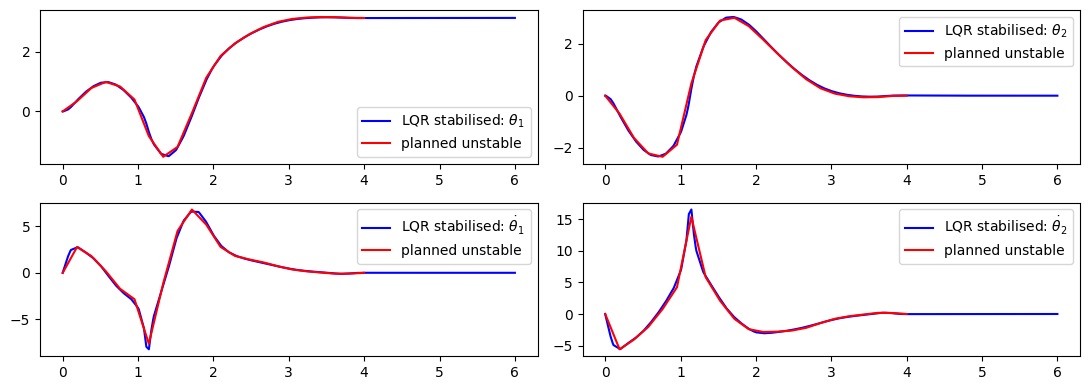

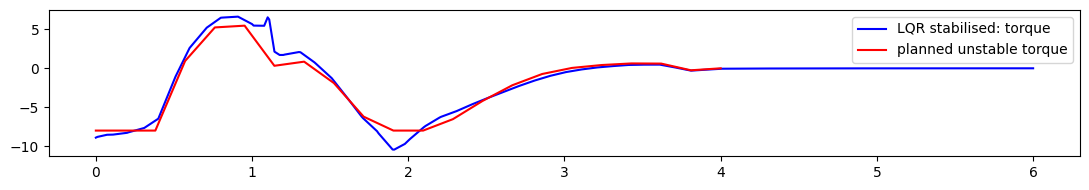

In [19]:
state_names = [r"$\theta_1$", r"$\theta_2$", r"$\dot{\theta}_1$", r"$\dot{\theta}_2$"]
fig, axs = plt.subplots(2, 2, figsize=(11, 4))
for i, ax in enumerate(axs.flatten()):
    ax.plot(
        results.time,
        results.outputs["x"][:, i],
        "-b",
        label=r"LQR stabilised: " + state_names[i],
    )
    ax.plot(t_vec, x_opt_hs[:, i], "-r", label="planned unstable")
    ax.legend()
fig.tight_layout()

state_names = [r"$\theta_1$", r"$\theta_2$", r"$\dot{\theta}_1$", r"$\dot{\theta}_2$"]
fig, ax = plt.subplots(1, 1, figsize=(11, 2))
ax.plot(
    results.time, results.outputs["u_opt"][:, 0], "-b", label=r"LQR stabilised: torque"
)
ax.plot(t_vec, u_opt_hs[:, 0], "-r", label="planned unstable torque")
ax.legend()
fig.tight_layout()

In summary, we have demonstrated the usage of a collocation method in Collimator for trajectory optimization, and subsequent trajectory stabilization with finite-horizon LQR. We refer the reader to the excellent notes [1] on LQR for an extensive treatment.

**References**:
> [1] Russ Tedrake. Underactuated Robotics: Algorithms for Walking, Running, Swimming, Flying, and Manipulation (Course Notes for MIT 6.832). [Available online.](https://underactuated.csail.mit.edu/)